### External imports

In [1]:
# imports
import numpy as np
from numpy.lib.stride_tricks import as_strided
import cupy as cp
from scipy import signal, misc

import math
import time
import importlib

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Internal Imports

In [2]:
import plot_utility as pu

### Create - Data, Consts, Pars, Lower Bound, Upper Bound

In [15]:
nparam = 4

slice_start = 15
slice_stop = 35

# Data
data = None
with open('data_ivim.npy', 'rb') as f:
    data = np.load(f)[:,:,slice_start:slice_stop,:]
nvoxels = data.shape[0] * data.shape[1] * data.shape[2]
ndata = data.shape[3]
data_flat = data.flatten().reshape((1, ndata*nvoxels), order='C')

# Consts
consts = None
with open('bvals_ivim.npy', 'rb') as f:
    consts = np.load(f)
consts_flat = np.empty((1, ndata*nvoxels), dtype=np.float32, order='C')
for i in range(0,ndata):
    consts_flat[:,i::21] = consts[i]

# Pars
pars_dipy = None
with open('pars_ivim_dipytrr.npy', 'rb') as f:
    pars_dipy = np.load(f)[:,:,slice_start:slice_stop,:]
#pars_flat = np.transpose(pars_dipy, (3,0,1,2)).reshape((nparam,nvoxels),order='C')
pars_flat = np.empty((nparam, nvoxels), dtype=np.float32)
pars_flat[0,:] = 10000 #pars_dipy[:,:,:,0].flatten()
pars_flat[1,:] = 0.5 #pars_dipy[:,:,:,1].flatten()
pars_flat[2,:] = 0.05 #pars_dipy[:,:,:,2].flatten()
pars_flat[3,:] = 0.002 #pars_dipy[:,:,:,3].flatten()

lower_bound = cp.empty((nparam, nvoxels), dtype=np.float32)
lower_bound[0,:] = np.finfo(np.float32).min
lower_bound[1,:] = 0.0
lower_bound[2,:] = 0.0
lower_bound[3,:] = 0.0

upper_bound = cp.empty((nparam, nvoxels), dtype=np.float32)
upper_bound[0,:] = np.finfo(np.float32).max / 2
upper_bound[1,:] = 1.0
upper_bound[2,:] = 0.5
upper_bound[3,:] = 0.1

In [16]:
import cuda.lsqnonlin as clsq
importlib.reload(clsq)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

nchunks = 1
chunk_size = math.ceil(nvoxels / nchunks)

first_f = np.empty((1, nvoxels), dtype=np.float32)
last_f = np.empty((1, nvoxels), dtype=np.float32)

solm = clsq.SecondOrderLevenbergMarquardt(expr, pars_str, consts_str, ndata=ndata, dtype=cp.float32, write_to_file=True)

start = time.time()
for i in range(0,nchunks):

	ptemp = pars_flat[:,i*chunk_size:(i+1)*chunk_size].copy(order='C')
	ctemp = consts_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata].copy(order='C')
	dtemp = data_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata].copy(order='C')
	ltemp = lower_bound[:,i*chunk_size:(i+1)*chunk_size].copy(order='C')
	utemp = upper_bound[:,i*chunk_size:(i+1)*chunk_size].copy(order='C')

	parscu = cp.array(ptemp, dtype=cp.float32, copy=True, order='C')
	constscu = cp.array(ctemp, dtype=cp.float32, copy=True, order='C')
	datacu = cp.array(dtemp, dtype=cp.float32, copy=True, order='C')
	lower_bound_cu = cp.array(ltemp, dtype=cp.float32, copy=True, order='C')
	upper_bound_cu = cp.array(utemp, dtype=cp.float32, copy=True, order='C')

	solm.setup(parscu, constscu, datacu, lower_bound_cu, upper_bound_cu)
	solm.run(100, 1e-30)

	first_f[:,i*chunk_size:(i+1)*chunk_size] = solm.first_f.get()
	last_f[:,i*chunk_size:(i+1)*chunk_size] = solm.last_f.get()

	pars_flat[:,i*chunk_size:(i+1)*chunk_size] = parscu.get()

end = time.time()
print('It took: ' + str(end - start) + ' s')



It took: 535.4620909690857 s


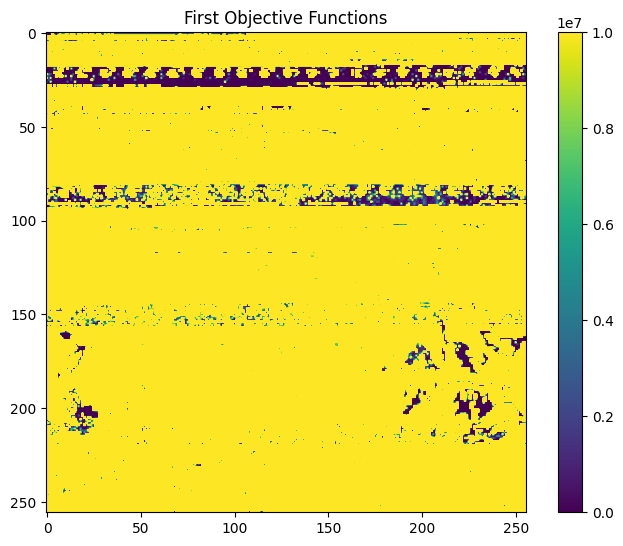

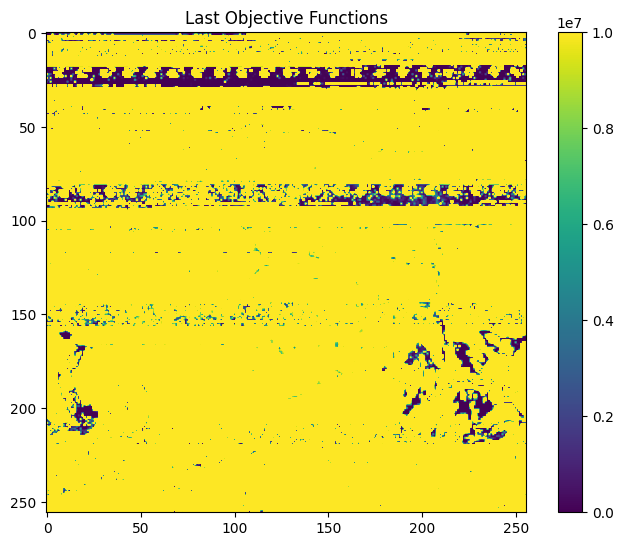

In [11]:
ffig1 = plt.figure()
fax1 = ffig1.add_axes([0,0,1,1])
ffigdata1 = fax1.imshow(np.reshape(first_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,15])
fax1.set_title('First Objective Functions')
ffigdata1.set_clim(0.0, 1e7)
ffig1.colorbar(ffigdata1, ax=fax1)

ffig2 = plt.figure()
fax2 = ffig2.add_axes([0,0,1,1])
ffigdata2 = fax2.imshow(np.reshape(last_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,15])
fax2.set_title('Last Objective Functions')
ffigdata2.set_clim(0.0, 1e7)
ffig2.colorbar(ffigdata2, ax=fax2)

In [12]:
pars_flat_back = np.transpose(np.reshape(pars_flat, (4, data.shape[0], data.shape[1], data.shape[2])), (1,2,3,0))


In [7]:
gemask = pars_flat_back[:,:,:,2] < pars_flat_back[:,:,:,3]

temp = pars_flat_back[gemask, 2].copy()
pars_flat_back[gemask, 2] = pars_flat_back[gemask, 3].copy()
pars_flat_back[gemask, 3] = temp.copy()
pars_flat_back[gemask, 1] = 1 - pars_flat_back[gemask, 1]


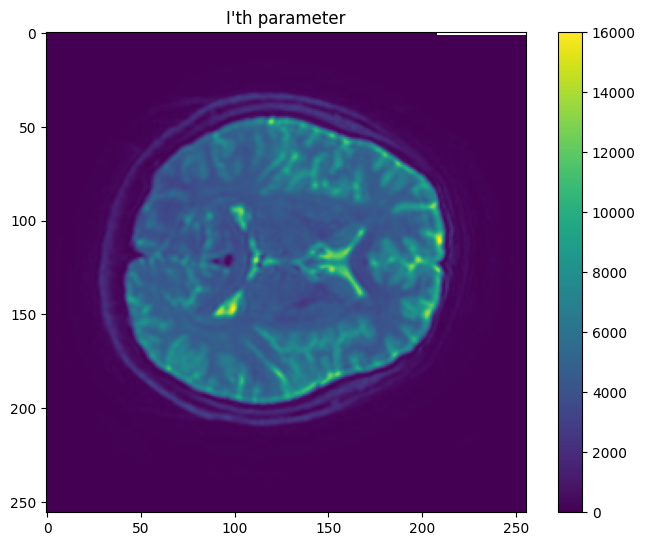

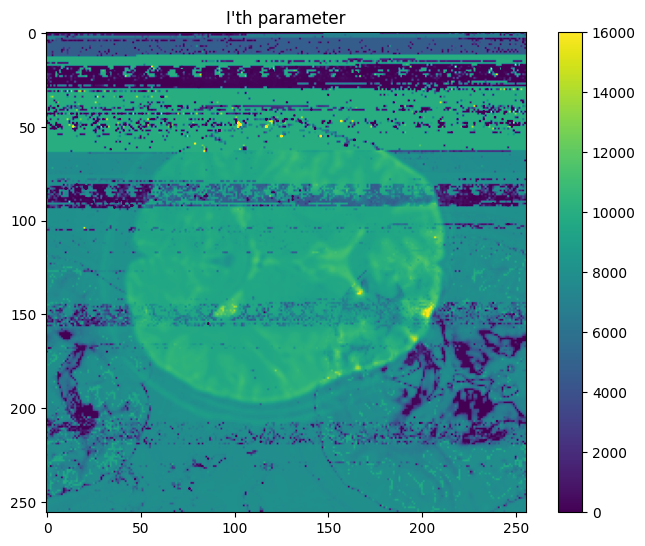

In [13]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=15, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[0])

pu.param_printer(pars_flat_back, slicez=15, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[0])


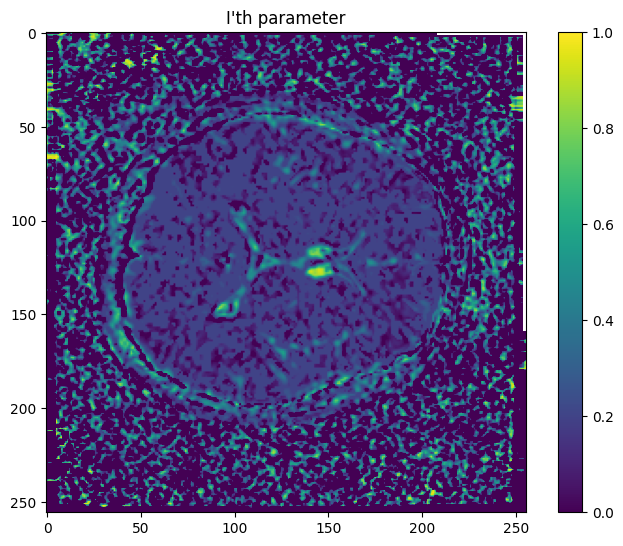

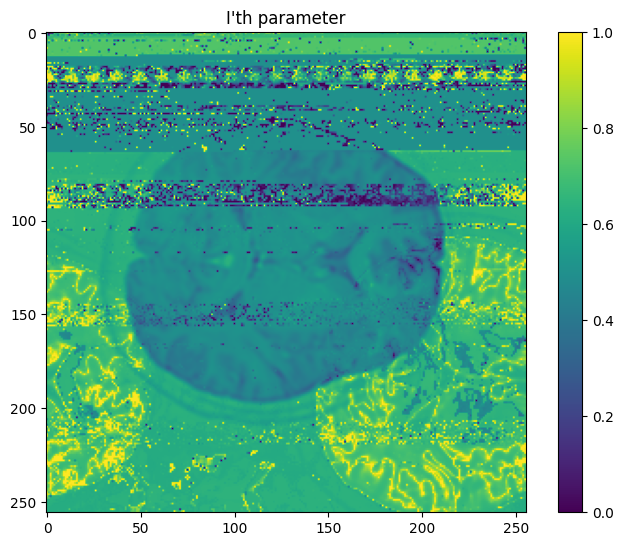

In [14]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[1])

pu.param_printer(pars_flat_back, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[1])


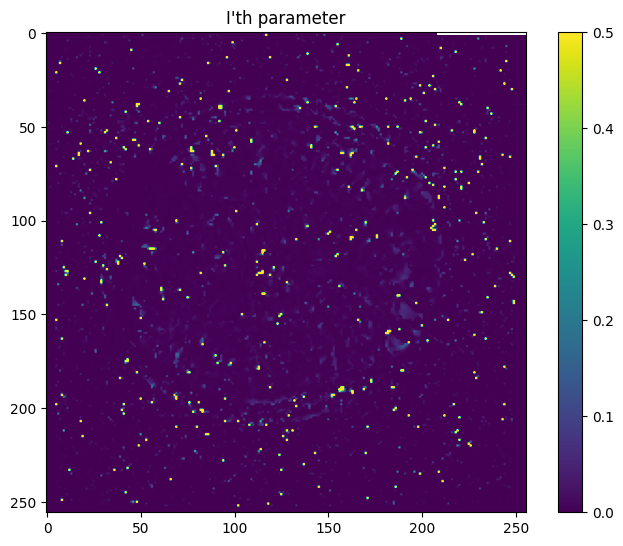

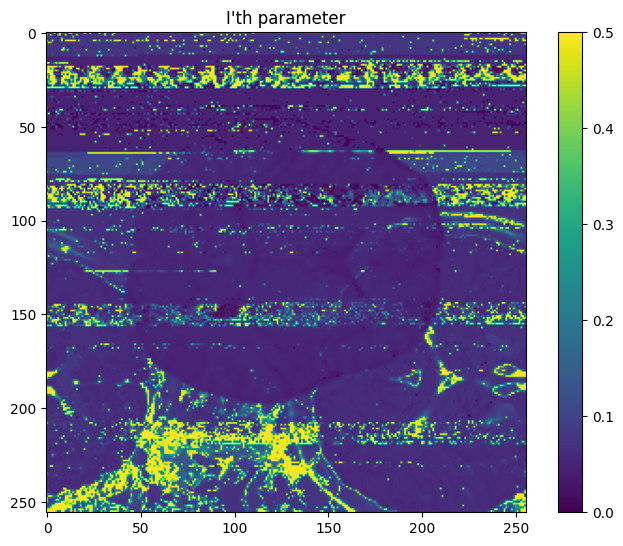

In [9]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=15, clim=[0.0, 0.5], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[2])

pu.param_printer(pars_flat_back, slicez=15, clim=[0.0, 0.5], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[2])


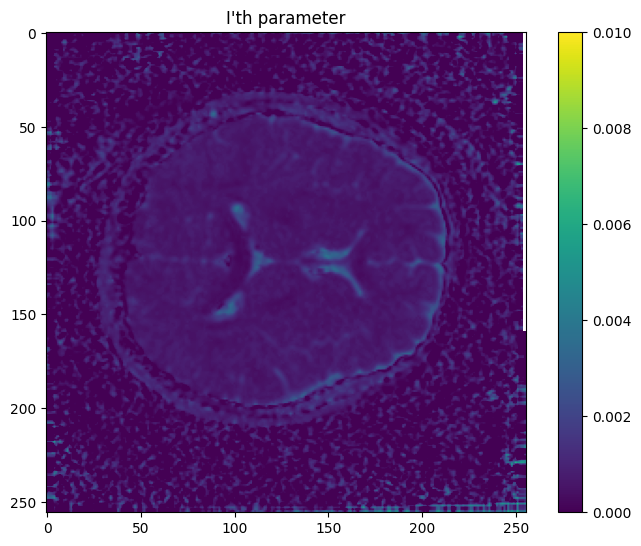

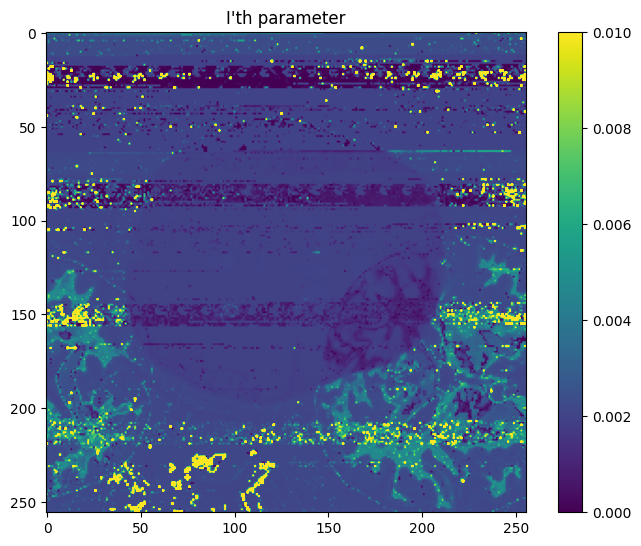

In [10]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=15, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[3])

pu.param_printer(pars_flat_back, slicez=15, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[3])


[1.0015200e+04 4.9736148e-01 4.9053233e-02 1.9717340e-03]
[7396.711  7112.9795 6719.427  6491.7373 6325.9116 6033.024  6031.312
 5402.7217 4972.341  4610.501  4181.36   4611.644  4306.3384 3535.955
 2669.6287 2414.327  2034.8687 1900.4879 1683.2178 1429.4044 1413.2815]


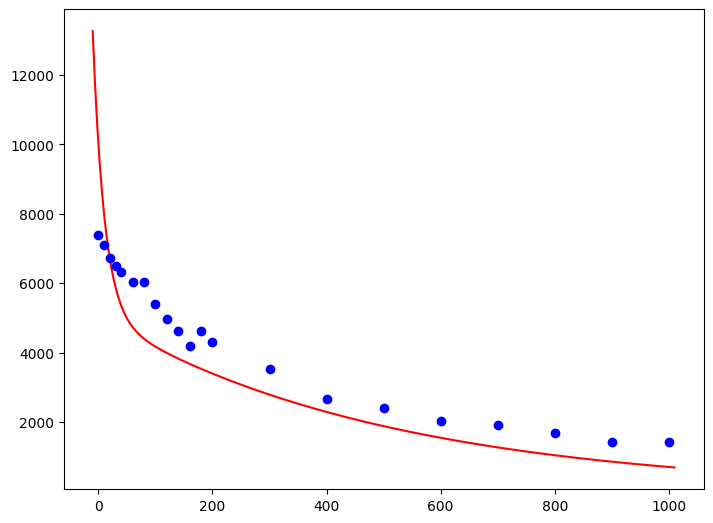

In [11]:
importlib.reload(pu)

pars_to_plot = pars_flat_back[120,120,15,:]
data_to_plot = data[120,120,15,:]
print(pars_to_plot)
print(data_to_plot)

pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_to_plot, consts, data_to_plot)

[9.8386797e+03 5.0393832e-01 5.9544973e-02 2.0076549e-03]
[3479.5654 3271.977  3282.4246 3318.635  3118.6128 3266.4312 3074.3882
 3037.9998 2969.6694 2879.9956 2675.4143 2642.063  2703.7383 2410.162
 2215.8674 2089.4355 2022.9293 1868.03   1688.9039 1644.0437 1461.3623]


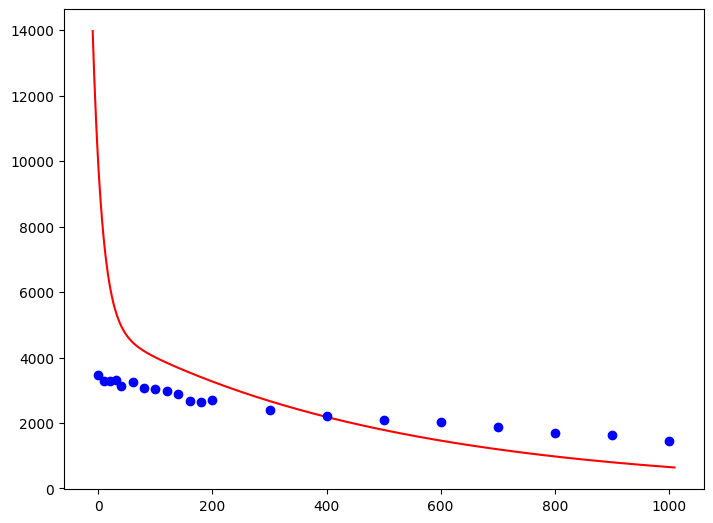

In [12]:
importlib.reload(pu)

pars_to_plot = pars_flat_back[140,140,15,:]
data_to_plot = data[140,140,15,:]
print(pars_to_plot)
print(data_to_plot)

pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_to_plot, consts, data_to_plot)